In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

**<span style="font-size: 20px;">№1. Восстановление последовательности данных с помощью RBM</span>**

**<span style="font-size: 18px;">Генерация данных</span>**

<span style="color:rgb(182, 181, 181); font-size: 16px;">Создадим синусоидальную последовательность для демонстрации работы RBM</span>

In [8]:
# Создаем равномерную сетку времени
t = np.linspace(0, 8 * np.pi, 2000)
# Генерируем синусоидальный сигнал
y = np.sin(t)

**<span style="font-size: 18px;">Подготовка данных для RBM</span>**

<span style="color:rgb(182, 181, 181); font-size: 16px;">RBM ожидает данные в виде "окон" фиксированного размера</span>

In [9]:
# Размер окна для создания признаков
n_points = 120

# Создаем матрицу признаков, где каждая строка - это окно из n_points последовательных значений
x = np.array([y[i:i + n_points] for i in range(len(y) - n_points)])

# Масштабируем данные в диапазон [0, 1], так как RBM работает лучше с бинарными данными
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)

**<span style="font-size: 18px;">Обучение модели RBM</span>**

In [10]:
# Создаем и обучаем RBM
rbm = BernoulliRBM(
    n_components=60,  # Количество скрытых нейронов
    learning_rate=0.02,  # Скорость обучения
    batch_size=64,  # Размер батча
    n_iter=600,  # Количество итераций обучения
    random_state=42
)
rbm.fit(x)

BernoulliRBM(batch_size=64, learning_rate=0.02, n_components=60, n_iter=600,
             random_state=42)

**<span style="font-size: 18px;">Восстановление последовательности</span>**

<span style="color:rgb(182, 181, 181); font-size: 16px;">Используем обученную RBM для восстановления исходной последовательности</span>

In [11]:
# Инициализируем массив для предсказаний
y_pred = np.zeros_like(y)
N = 50  # Количество итераций Гиббса для усреднения

for k in range(N):
    # Генерируем новые данные с помощью Гиббсовского сэмплирования
    x_pred = rbm.gibbs(x)
    # Обратное масштабирование к исходному диапазону
    x_pred = scaler.inverse_transform(x_pred)
    
    # Восстанавливаем последовательность из окон
    for i in range(len(y)):
        # Находим все окна, которые содержат текущую точку
        indices = [j for j in range(len(x_pred)) if 0 <= i - j < n_points]
        # Собираем значения для текущей точки из всех окон
        point_vals = [x_pred[j][i - j] for j in indices]
        # Усредняем значения
        y_pred[i] += np.mean(point_vals) if point_vals else 0

# Усредняем по количеству итераций
y_pred = y_pred / N

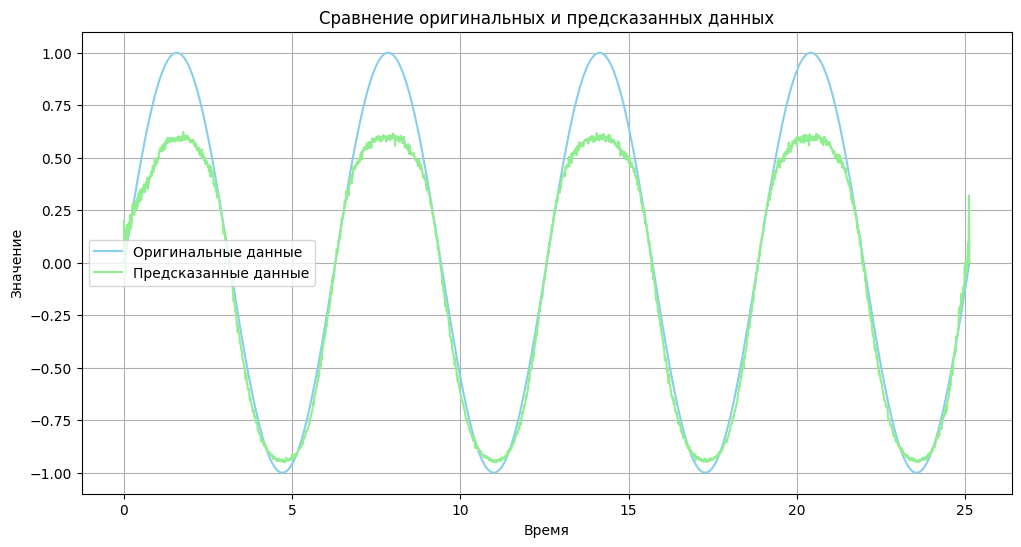

In [12]:
plt.figure(figsize=(12, 6))

# Оригинальная последовательность
plt.plot(t, y, label='Оригинальные данные', color='skyblue')

# Восстановленная последовательность
plt.plot(t[:len(y_pred)], y_pred, label='Предсказанные данные', color='lightgreen')

plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Сравнение оригинальных и предсказанных данных')
plt.legend()
plt.grid(True)
plt.show()

**<span style="font-size: 18px;">Оценка качества восстановления</span>**

In [13]:
# Удаляем NaN значения для корректного расчета метрик
valid_indices = ~np.isnan(y_pred)

# Вычисляем метрики
rmse = root_mean_squared_error(y[valid_indices], np.array(y_pred)[valid_indices])
r2 = r2_score(y[valid_indices], np.array(y_pred)[valid_indices])

print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 0.1800
R2 Score: 0.9352


**<span style="font-size: 20px;">№2. Рекомендательная система</span>**

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

**<span style="font-size: 18px;">Загрузка и подготовка данных</span>**

In [23]:
# Загрузка данных о рейтингах
ratings = pd.read_csv('data/ratings_small.csv')
ratings['movieId'] = ratings['movieId'].astype(str)  # Для корректного слияния

# Создание матрицы пользователь-фильм
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

# Масштабирование данных
scaler = MinMaxScaler(feature_range=(0, 1))
user_movie_matrix = pd.DataFrame(
    scaler.fit_transform(user_movie_matrix),
    columns=user_movie_matrix.columns,
    index=user_movie_matrix.index
)

# Замена пропущенных значений нулями
user_movie_matrix = user_movie_matrix.fillna(0)

# Разделение на обучающую и тестовую выборки
train, test = train_test_split(user_movie_matrix, test_size=0.2, random_state=42)

user_movie_matrix

movieId,1,10,100,100017,100032,100034,100083,100106,100159,100163,...,99795,998,99811,99813,99839,99846,999,99912,99917,99992
userId,,,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**<span style="font-size: 18px;">Обучение RBM для рекомендательной системы</span>**

In [16]:
rbm = BernoulliRBM(
    n_components=50,
    learning_rate=0.01,
    batch_size=32,
    n_iter=500,
    random_state=42
)
rbm.fit(train)

BernoulliRBM(batch_size=32, learning_rate=0.01, n_components=50, n_iter=500,
             random_state=42)

**<span style="font-size: 18px;">Функция для предсказания рейтингов</span>**

In [17]:
def predict_rating(user_id, user_movie_matrix, N=50):
    """Предсказание рейтингов для пользователя"""
    user_vector = user_movie_matrix.loc[user_id].values.reshape(1, -1)
    
    predicted_ratings = np.zeros_like(user_vector)
    for _ in range(N):
        y_pred = rbm.gibbs(user_vector)
        y_pred = scaler.inverse_transform(y_pred)
        predicted_ratings += y_pred
    return predicted_ratings[0] / N

**<span style="font-size: 18px;">Оценка модели на тестовых данных</span>**

In [18]:
all_true = []
all_pred = []

for user_id in test.index:
    # Получаем реальные рейтинги пользователя
    user_ratings = ratings[ratings['userId'] == int(user_id)]
    # Находим фильмы, которые есть и в тестовой выборке, и в реальных рейтингах
    common_movies = list(set(user_ratings['movieId']) & set(test.columns))
    
    if not common_movies:
        continue

    # Реальные рейтинги
    true_ratings = user_ratings[user_ratings['movieId'].isin(common_movies)].sort_values('movieId')['rating'].values

    # Предсказанные рейтинги
    pred_ratings = predict_rating(user_id, test)
    movie_indices = [test.columns.get_loc(m) for m in common_movies]
    pred_ratings = pred_ratings[movie_indices]
    
    all_true.extend(true_ratings)
    all_pred.extend(pred_ratings)

# Вычисление метрик
rmse = root_mean_squared_error(all_true, all_pred)
r2 = r2_score(all_true, all_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 2.1345
R2 Score: -2.9180


In [19]:
movies = pd.read_csv('data/movies_metadata.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_10736\2749279268.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('data/movies_metadata.csv')


**<span style="font-size: 18px;">Функция для получения рекомендаций</span>**

In [20]:
def get_recommendations(user_id, data, N=50, top_n=10):
    """Получение рекомендаций для пользователя"""
    user_vector = data.loc[user_id].values.reshape(1, -1)
    
    # Предсказание рейтингов
    predicted_ratings = np.zeros_like(user_vector)
    for _ in range(N):
        y_pred = rbm.gibbs(user_vector)
        y_pred = scaler.inverse_transform(y_pred)
        predicted_ratings += y_pred.flatten()
    predicted_ratings = predicted_ratings.flatten() / N
    
    # Создание DataFrame с предсказаниями
    recommendations = pd.DataFrame({
        'movieId': data.columns,
        'predicted_rating': predicted_ratings
    })
    
    # Добавление информации о фильмах
    recommendations = pd.merge(
        recommendations, 
        movies, 
        left_on='movieId', 
        right_on='id', 
        how='left'
    )
    
    # Сортировка по предсказанному рейтингу
    recommendations = recommendations.sort_values('predicted_rating', ascending=False)
    
    return recommendations.head(top_n)

**<span style="font-size: 18px;">Пример рекомендаций для пользователя</span>**

In [21]:
user_id = 1  # Пример пользователя
recommendations = get_recommendations(user_id, user_movie_matrix)

print(f'Топ-10 рекомендаций для пользователя {user_id}:')
recommendations[['movieId', 'predicted_rating', 'title']]

Топ-10 рекомендаций для пользователя 1:


,movieId,predicted_rating,title
3863,3737,5.02,NaN
5549,53,5.02,NaN
8947,97230,5.02,NaN
8987,98126,5.00,NaN
1263,153584,5.00,NaN
7627,7564,5.00,NaN
9003,98587,5.00,NaN
26,100553,5.00,NaN
9025,99030,5.00,NaN
2272,25801,5.00,Aamdani Atthanni Kharcha Rupaiya


**<span style="font-size: 20px;">Выводы:</span>**

<span style="color:rgb(182, 181, 181); font-size: 16px;">
	1. Для задачи восстановления последовательности RBM показала: <br />
	• Достаточно хорошее качество восстановления синусоиды <br />
	• Возможность улавливать последовательные зависимости в данных
</span>

<span style="color:rgb(182, 181, 181); font-size: 16px;">
	2. Для рекомендательной системы: <br />
	• Модель показывает не лучшие результаты (RMSE: 2.1345, R2 Score: -2.9180) из-за недостаточности данных в датасете
</span>